# Simple baseline algorithm to get some start point

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

I got data from [here](http://www.ee.cuhk.edu.hk/~syi/). It includes folder Annotation (now Csv) (which consists of txt-file describing path for each of 12684 pedestrians) and folder Frame (6001 frames with pictures of observed area).

In [3]:
# amount of data in src/Csv folder
NUMBER_OF_PEDESTRIANS = 12684

TRAIN_NUMBER = 10569
TEST_NUMBER = 2115

assert TRAIN_NUMBER + TEST_NUMBER == NUMBER_OF_PEDESTRIANS

Points are stored like [X1, Y1, X2, Y2, ...].
So we need to calculate distance between them and double that distance to perform some operations with same shape arrays.

In [10]:
# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    error_template = "Array lengths should be equal. len(array1): {len1}, len(array2): {len2}"
    assert (len(array1) == len(array2)), error_template.format(len1=len(array1), len2=len(array2))
    
    length = len(array1)
    # array1[i:i+2] -- point i from first array
    # np.linalg.norm -- calculate distance between points
    distance = np.array([np.linalg.norm(array1[i:i+2] - array2[i:i+2]) for i in range(0,length,2)])
    
    return np.array([[d, d] for d in distance]).flatten()

In [24]:
# input consists of list of points
# function get some two of them (the last one and %start_point%), build a vector with the same direction
# and returns %number_of_points_to_return% points (5 by default) on this vector with equal distance between them
# distance can be equal to last vector distance (by default) or to mean distance of all vectors (mean_distance=True)

def get_vector_linear_continuation(dataframe, start_point_index=0, number_of_points_to_return=5):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(dataframe) - 1), error_template.format(st=start_point_index, end=len(dataframe) - 1)
    
    start_point = np.array(dataframe)[start_point_index]
    last_but_one_point = np.array(dataframe)[-2]
    end_point = np.array(dataframe)[-1]
    
    distance = distance_for_each_point(end_point, start_point)
    normalized_motion_vector = (end_point - start_point) / distance
    normalized_motion_vector[np.where(distance == 0)] = 0
    last_vector_length = distance_for_each_point(end_point, last_but_one_point)
    
    motion_vector = normalized_motion_vector * last_vector_length
    result = []
    for i in range(number_of_points_to_return):
        result.append(end_point + (i + 1) * motion_vector)
        
    return np.array(result)

In [4]:
ZERO_PADDING = 6

def get_filename(index):
    return "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))

NUMBER_OF_PEDESTRIANS = 12273

def download_pedestrian(index):
    error_message_template = "Pedestrian number should be between 0 and {max}; given number: {id}"
    assert(0 <= index < NUMBER_OF_PEDESTRIANS), error_message_template.format(max=NUMBER_OF_PEDESTRIANS-1, id=index)
    filename = get_filename(index)
    data = pd.read_csv(filename, index_col=0)
    return data

In [5]:
# in each row: {index; category; frames_number; label}
labels = pd.read_csv('src/pedestrian_labels_and_test_and_train_separation.csv', index_col=0)

Here we will get some data such as mean frames for pedestrians or difference between real pedestrian's coordinates and predicted through get_vector_linear_continuation with different paremeters.

In [6]:
labels['frames_number'].mean(), labels['frames_number'].min(), labels['frames_number'].max()

(36.95486026236454, 10, 995)

In [7]:
data = pd.DataFrame()

for index in range(1, NUMBER_OF_PEDESTRIANS + 1):
    if labels['category'][index] == 'train':
        continue

    # in each row: {index (time); X; Y}    
    pedestrian_data = download_pedestrian(index)[:10].reset_index()[['X', 'Y']]
    
    # in each row: {X; Y; X; Y; ...}
    data = pd.concat([data, pedestrian_data], axis=1)

In [8]:
data.to_csv('src/Logs/161002_first_ten_coordinates_from_test.csv')

In [9]:
input_coordinates = data[:5]
real_coordinates = data[5:10]

In [33]:
predicted_coordinates = []

# i will be start point index
for i in range(4):
    predicted_coordinates.append(get_vector_linear_continuation(input_coordinates, start_point_index=i))

predicted_coordinates = np.array(predicted_coordinates)
np.save('src/Logs/161003_predicted_coordinates_for_baseline_all_startpoints', predicted_coordinates)

In [35]:
result = []
for i in range(4):
    result.append(distance_for_each_point(np.array(real_coordinates), predicted_coordinates[i]).sum())

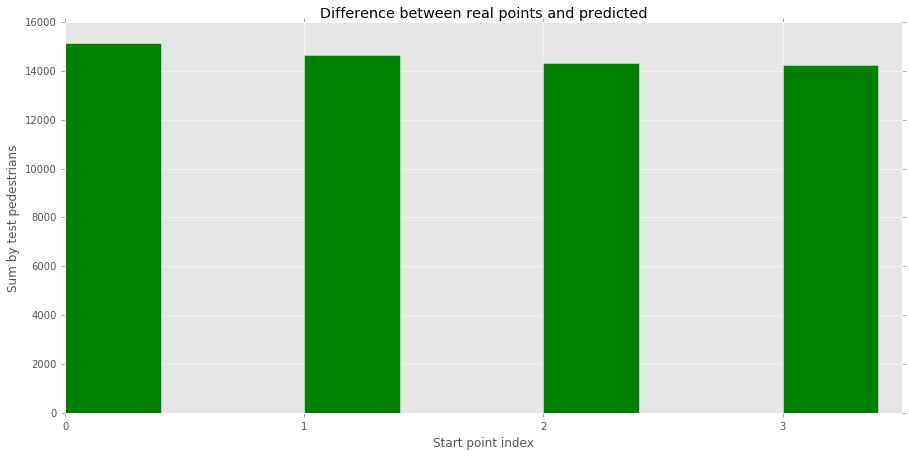

In [38]:
ind = np.arange(4)
width = 0.4
result_bar = plt.bar(ind, result, width, color='g')

plt.ylabel('Sum by test pedestrians')
plt.xlabel('Start point index')
plt.title('Difference between real points and predicted')
plt.xticks(ind)
plt.savefig('src/Plots/161003_difference_between_real_points_and_predicted.png')

As we can see, it's better to get last but one point as start point.